# Linear Regression

More generally, a linear model make prediction by simply computing a weighted sum of the input features, plus a constant called the *bias term* (also called the *intercept term*)

To train a Linear Regression model, you need to find the value of θ that minimizes the RMSE. In practice, it is simpler to minimize the Mean Square Error (MSE) than RMSE, and it leads to the same result.

## The Normal Equation (正规方程)

To find the value of θ that minimizes the cost function, there is a *closed-form solution*-- in other words, a mathematical equation that gives the result directly. This is called the *Noemal Equation*.

Let's generate some linear-looking data to test this equation.

In [55]:
import numpy as np

X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

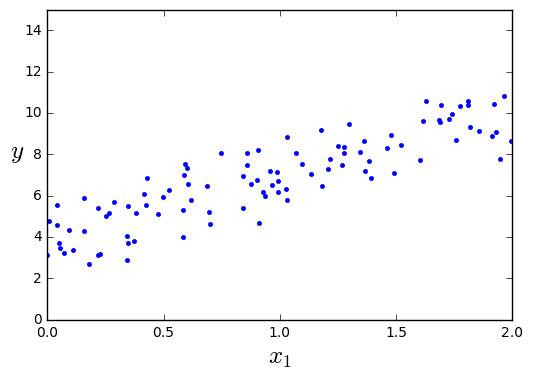

In [56]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

Now, we will compute θ using the Normal Equation.

*inv()* function from Numpy's Linear Algebra module (np.linalg) to compute the inverse of a matrix.

*dot()* method is for matrix multiplication.

In [57]:
X_b = np.c_[np.ones((100,1)), X]  #add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

The actual function that we used to generate the data is y = 4 + 3x0 + Gaussian noise. Let's see what the equation found:

In [58]:
theta_best

array([[3.89231574],
       [3.11806124]])

Close enough, but the noise made it impossible to recover the exact parameters of the original function.

We can now make predictions using *theta_best*.

In [59]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.89231574],
       [10.12843822]])

We can plot this model's predictions:

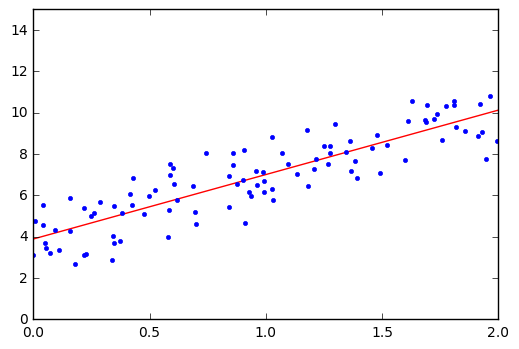

In [60]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0,2,0,15])
plt.show()

The equivalent code using Scikit-Learn looks like this:

In [61]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
print(lin_reg.intercept_, lin_reg.coef_)
print(lin_reg.predict(X_new))

[3.89231574] [[3.11806124]]
[[ 3.89231574]
 [10.12843822]]


## Computational Complexity

The *computational complexity* of inverting such a matrix is typically about O(n^2.4) to O(n^3) (depending on the implementation). In other words, if you double the number of features, you multiply the computation time by roughly 2^2.4=5.3 to 2^3=8.

On the positive side:
+ This equation is linear to the number of instances in the training set (it is O(m)).
- Also, once you have trained your Linear Regression model (using the Normal Equation or other algorithm)< predictions are very fast.

# Gradient Descent

*Gradient Descent* is a very generic optimation algorithm capable of finding optimal solutions to a awide range of problems. The general idea of Gradient Descent is to tweak parameters iteratively in order to minimize a cost function.

Concretely, you start by filling θ with random values (this is called *random initialization*), and then you improve it gradually, taking one baby step at a time, each step attempting to decrease the cost function (e.g., the MSE), until the algorithm *converges* to a minimum.

An important parameter in Gradient Descent is the size of steps, determined by the *learning rate* hyperparameter.

Not all cost functions look like nice regular bowls. There may be holes, ridges, plateaus, and all sorts of irregular terrains, making convergence to the minimum very difficult.

When using Gradient Descent, you should ensure that all features have a similar scale (e.g., using Scikit-Learn's *StandardScaler* class), or else it will take much longer to converge.

The essence of training a model is searching for a combination of model parameters that minimizes a cost function (over the training set).

## Batch Gradient Descent

To implement Gradient Descent, you need to compute the gradient of the cost function with regrads to each model parameter θj. In other words, you need to calculate how much the cost function will change if you change θj just a little bit. This is called a *partial deriative*

Once you have the gradient vector, which points uphill, hust go in the opposite direction to go downhill. This means subtracting ∇θ MSE(θ) from θ. This is where the learning rate η comes into play: multiply the gradient vector by η to determine the size of the downhill step.

θ(next step) = θ - η∇θMSE(θ)

It is a quick implementation of this algorithm:

In [62]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  #random initializaion

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

Let's look at the resulting *theta*:

In [63]:
theta

array([[3.89231574],
       [3.11806124]])

To find a good learning rate, you can use grid search. However, you may want to limit the number of iterations so that the grid search can eliminate models that take too long to converge.

You may wonder how to set the number of iterations. A simple solution is to set a very large number of iterations but to interrupt the algorithm when the gradient vector becomes tiny -- that is, when its norm becomes smaller than a tiny number ε (called the *tolerance*) -- because this happens when Gradient Descent has (almost) reached the minimum. 

## Stochastic Gradient Descent

The main problem with Batch Gradient Descent is the fact that it uses the whole training set to compute the gradients at every step, which makes it very slow when the training set is large. At the opposite extreme, *Stochastic Gradient Descent* just picks a random instance in the training set at every step and computes the gradients based only on that single instance.

Instead of gently decreasing until it reaches the minimun, the cost function will bounce up and down, decreasing only on average. So once the algorithm stops, the final parameter values are good, but not optimal.

When the cost function is very irregular, this can actually help the algorithm jump out of local minima, so Stochastic Gradient Descent has a better chance of finding the global minimum than Batch Gradient Descent does.

Therefore randomness is good to escape from local optima, but bad because it means that the algorithm can never settle at the minimum. One solution to this dilemma is to gradually reduce the learning rate. The steps start out large (which helps make quick progress and escape local minima), then get smaller and smaller, allowing the algorithm to settle at the global minimum. This process is called *simulated annealing(模拟退火)*. The function that determines the learning rate at each iteration is called the *learning schedule*.

The code implements Stochastic Gradient Descent using a simple learning schedule.

In [64]:
n_epochs = 50
t0, t1 = 5, 50  #learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  #random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(m * epoch + i)
        theta = theta - eta * gradients

Then we get the theta.

In [65]:
theta

array([[3.84062337],
       [3.08950601]])

To perform Linear Regression using SGD with Scikit-Learn, you can use the *SGDRegressor* class, which defaults to optimizing the squared error cost function. The following code runs 50 epochs, starting with a learning rate of 0.1 (eta0=0.1), using the default learning schedule (different from the preceding one), and it does not use any regularization (penalty=None; more details on this shortly):

In [66]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(n_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.1,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=50, penalty=None, power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

Once again, you find a solution very close to the one returned by the Normal Equation:

In [67]:
print(sgd_reg.intercept_, sgd_reg.coef_)

[3.91948422] [3.15934723]


## Mini-batch Gradient Descent

*Mini-Batch Gradient*: at each step, instead of computing the gradients basedon the full training set (as in Batch GD) or based on just on instance (as in SGD), Mini-Batch GD computes the gradients on small random sets of instances called *mini-batches*. The main advantage of Mini-batch GD over Stochastic GD is that you can get a performance boost from hardware optimization of matrix operations, especially when using GPUs.

The algorithm's progress in parameter space is less erratic than with SGD, especially with fairly large mini-batches. As a result, Mini-Batch GD will end up walking around a bit closer to the minimum than SGD. But, on the other hand, it may be harder for it to escape from local minima.

# Polynomial Regression

*Polynomial Regression*: Add powers of each feature as new features, then train a linear model on this extended set of features.

First, we generate some nonlinear data, based on a simple *quadratic equation*

In [68]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m ,1)

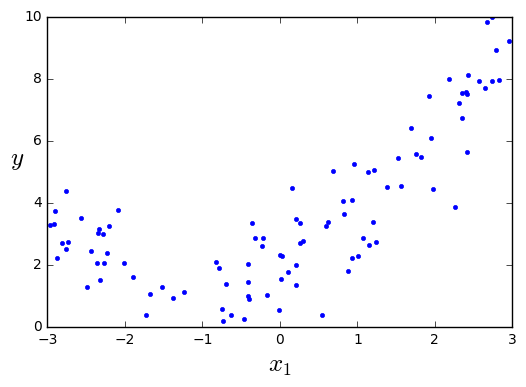

In [69]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

Clearly, a straight line will never fit this data properly. So let's use Scikit-Learn's *PolynomialFeatures* class to transform our training data, adding the square of each feature in the training set as new features.

In [70]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0])
print(X_poly[0])

[2.82430779]
[2.82430779 7.97671448]


X_poly now contains the original feature of X plus the square of this feature. Now you can fit a *LinearRegression* model to this extended training data.

In [71]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
print(lin_reg.intercept_, lin_reg.coef_)

[1.94958681] [[1.05082147 0.51390495]]


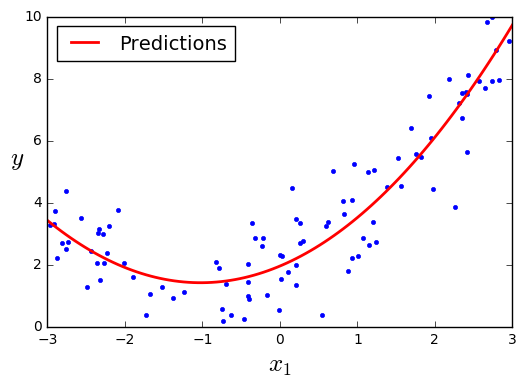

In [72]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.fit_transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

Note that when there are multiple features, Polynomial Regression is capable of finding relationships between features. But you should be aware of the combinatorial explosion of the number of features.

# Learning Curves

If you perform high-degree Polynomial Regression, you will likely fit the training data much better than with plain Linear Regression. Of course, this high-degree Polynomial Regression model is severely overfitting the training data, while the linear model is underfitting it.

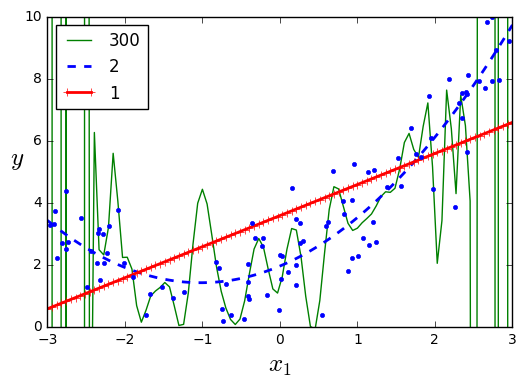

In [73]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("line_regression", lin_reg)
        ])
    polynomial_regression.fit(X,y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)
plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

+ How can you decide how complex your model should be?
- How can you tell that your model is overfitting or underfitting the data?

Two ways:
+ Use cross-validation to get an estimate of a model's generalization performance. If a model performs well on the training data but generalizes poorly according to the cross-validation metrics, then it is overfitting. If it performs poorly on both, then it is underfitting.
- Another way is to look at the *learning curves*: these are plots of model's performance on the training set and the validation set as a function of the training set size. To generate the plots, simply train the model several times on different sized subsets of the training set.

The following codes defines a function that plots the learning curves of a model given some training data.

In [74]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right")
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")

Let's look at the curves of the plain Linear Regression model.

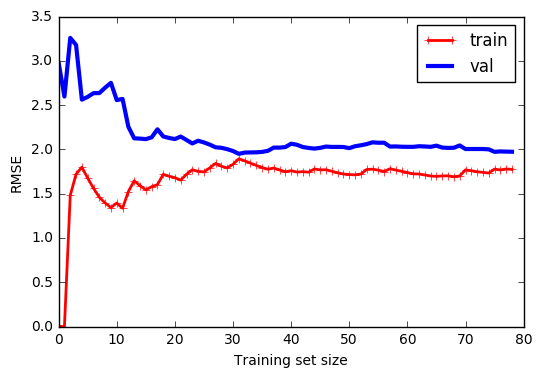

In [75]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

These learning curves are typical of an underfitting model. Both curvers have reached a plateau; they are close and fairly high.

Let's look at the learning curves of a 10th-degree polynomial model on the same data.

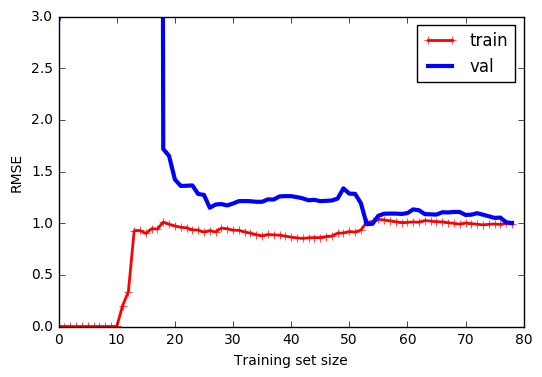

In [79]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("sgd_reg", LinearRegression())
    ])
plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3]) 
plt.show() 

Let's look at the learning curves of a 2th-degree polynomial model on the same data.

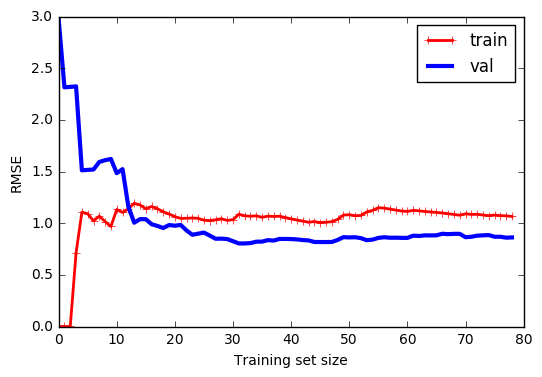

In [80]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("sgd_reg", LinearRegression())
    ])
plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3]) 
plt.show() 

# Regularized Linear Models

A good way to reduce overfitting is to regularize the model (i.e., to constrain it): the fewer degree of freedom it has, the harder it will be for it to overfit the data.

For a linear model, regularization is typically achieved by constraining the weights of the model. There are three ways to achieve this:
+ Ridge Regression
- Elastic Net
+ Lasso Regression

## Ridge Regression

*Ridge Regression* (also called *Tikhonov Regularization*) is a regularized version of Linear Regression: a *regularization term* equal to L2 norm(L2正则化) is added to the cost function.

Note that the regularization term should only be added to the cost function during training. Once the model is trained, you want to evaluate the model's performance using the unregularized performance measure.

The hyperparameter α controls how much you want to regularize the model. If α=0, then Ridge Regression is just Linear Regression. If α is very large, then all weights end up very close to zero and the result is a flat line going through the data's mean.

It is important to scale the data (e.g., using a *StandardScaler*) before performing Ridge Regression, as it is sensitive to the scale of the input features.

Here is how to perform Ridge Regression with Scikit-Learn using a closed-form solution:

In [99]:
X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

In [108]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([1.5])

C:\Users\13129\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[8.25022755]])

And using Schochastic Gradient Descent:

In [109]:
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([1.5])

C:\Users\13129\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([8.11854644])

The *penalty* hyperparameter sets the type of regularization term to use. Specifying "l2" indicates that you want SGD to add a regularization term to the cost function equal to half the square of the l2 norm of the weight vector: this is simply Ridge Regression.

## Lasso Regression

*Least Absolute Shrinkage and Selection Opreator Regression* (simply caleled *Lasso Regression*, 最小绝对值收敛和选择算子、套索算法) is another regularized version of Linear Regression: just like Ridge Regression, it adds a regularzation term to cost function, but it uses the *l1* norm of the weight vector instead of half of rhe square of the *l2* norm.

An important characteristic of Lasso Regression is that it tends to completely eliminate the weights of the least important features (i.e., set them to zero). In other words, Lasso Regression automatically performs feature selection and outputs a *sparse model* (i.e., with few nonzero feature weights)

Here is a small Scikit-Learn example using the *Lasso* class. Note that you can use an *SGDRegressor(penalty="l1")* as substitution.

In [110]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([1.5])

C:\Users\13129\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([8.13774566])

In [111]:
sgd_reg = SGDRegressor(penalty="l1")
sgd_reg.fit(X ,y)
sgd_reg.predict([1.5])

C:\Users\13129\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\13129\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([8.12224138])

## Elastic Net

Elastic Net is a middle ground between Ridge Regreesion and Lasso Regresson. The regularization term is a simple mix of both Ridge and Lasso's regularization terms, and you can control the mix ratio *r*.
+ When r = 0, Elastic Net is equivalent to Ridge Regression.
- When r = 1, Elastic Net is equivalent to Lasso Regression.

When should you use Linear Regression, Ridge, Lasso, or Elastic Net?
+ It is almost always preferable to have at least a little bit of regularization, so generally you should avoid plain Linear Regression.
- Ridge is a good default, but if you suspect that only a few features are actually useful, you should prefer Lasso or Elastic Net.
+ In general, Elastic Net is preferred over Lasso since Lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.

Here is a short example using Scikit-Learn's *ElasticNet* (*l1_ratio* corresponds to the mix ratio *r*).

In [114]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X,y)
elastic_net.predict([1.5])

C:\Users\13129\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([8.03436529])

## Early Stopping

A very different way to regularize iterative learning algorithms such as Gradient Descent is to stop training as soon as the validation error reaches a minimum. This is called *early stopping*.

With Stochastic and Mini-Batch GD, the learning curves are not so smooth, and it may br hard to know whether you have reached the minimum or not. One solution is to stop only after the validation error has been above the minimum for some time (when you are confident that the model will not do any better), then roll back the model parameters to the point where the validation error was at a minimum.

Here is the code that generates data and initializes polynomial scaler and SGDRegressor.

In [174]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50], test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

sgd_reg = SGDRegressor(n_iter=1, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)



Note that with *warm_start = True*, when *fit()* method is called, it just continues training where it left off instead of restarting from scratch.

In [175]:
from sklearn.base import clone

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.fit_transform(X_val)

n_epochs = 5000
train_errors, val_errors = [], []  # used only for graph
best_epoch = None
best_model = None
best_val_rmse = float("inf")

for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel())
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_error = mean_squared_error(y_train, y_train_predict)
    val_error = mean_squared_error(y_val, y_val_predict)
    train_errors.append(train_error)
    val_errors.append(val_error)
    if (val_error < best_val_rmse):
        best_epoch = epoch
        best_model = clone(sgd_reg)
        best_val_rmse = val_error

In [176]:
best_epoch, np.sqrt(best_val_rmse), best_model

(4202,
 0.9468177852323528,
 SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.0005,
        fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
        loss='squared_loss', n_iter=1, penalty=None, power_t=0.25,
        random_state=42, shuffle=True, verbose=0, warm_start=True))

Then, we can draw the figure.

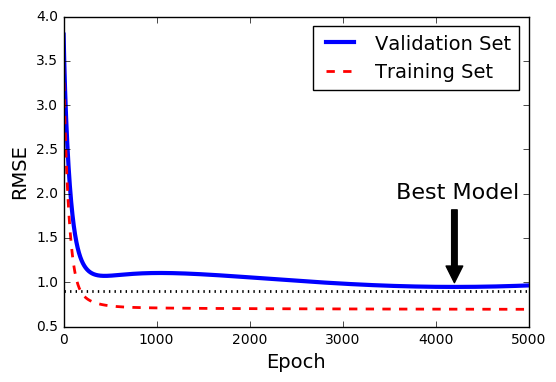

In [177]:
plt.annotate(" Best Model",
            xy=(best_epoch, np.sqrt(best_val_rmse)),
            xytext=(best_epoch, np.sqrt(best_val_rmse)+1),
            ha="center",
            arrowprops=dict(facecolor="black", shrink=0.05),
            fontsize=16
            )
#best_val_rmse -=0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation Set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training Set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

# Logistic Regression

*Logittic Regression* (also called *Logit Regression*) is commonly used to estimate the probability that an instance belongs to a particular class.
+ If the estimated probality is greater than 50%, then the model predicts that the instance belongs to that class (called the positive class, labeled "1")
- Else, it predicts that it does not (i.e, it belongs to the negative class, labeled "0")

## Estimating Probabilities

A Logistic Regression model computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the Linear Regression model does, it outputs the *logistic* of this result

The logistic -- also called the *logit*, noted σ(·) -- is a *sigmoid function* (i.e., S-shaped) that outputs a number between 0 and 1.

The following shows a logistic function:

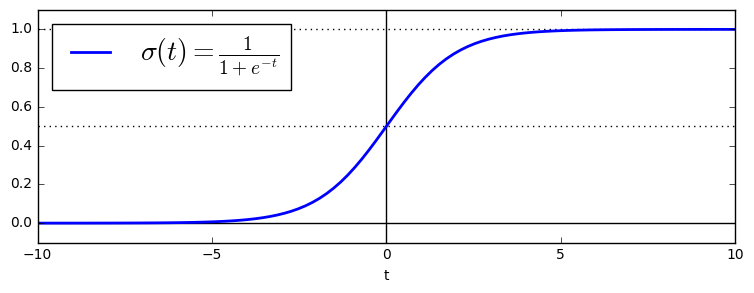

In [182]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

## Training and Cost function

The objective of training is to set the parameter vector θ so that the model estimates high probabilities for positive instances (y=1) and low probabilities for negative instances (y=0). Following is the cost function that captures this idea.

*Cost function* c(θ)=
+ -log(p)   (if y=1)
- -log(1-p)  (if y=0)

*Explanation*:
+ -log(t) grows very large when t approaches 0, so the cost will be large if the model estimates a probability close to 0 for a positive instance(y=1)
- -log(1-t) grows very large when t approaches 1, so the cost will be large if the model estimates a probability close to 1 for a negatice instance(y=0)
+ -log(t) is close to 0 when t is close to 1, so the cost will be small if the model estimates a probability close to 1 for a positive instance(y=1)
- -log(1-t) is close to 0 when t is close to 0, so the cost will be small if the model estimates a probability close to 0 for a negative instance(y=0)

The cost function over the whole training set is simply the average cost over all training instances. It is called *log loss*.

+ The bad news is that there is no known closed-form equation to compute the value of θ that minimizes the cost function.
- The good news is that this cost function is convex, so Gradient Descent (or any other optimization algorithm) is guaranteed to find the global minimum (if the learning rate is not too large and you wait long enough)

## Decision Boundaries

Let's use iris dataset to illustrate Logistic Regression. This is a famous dataset that contains the sepal and petal length ands width of 150 iris flowers of three different species: Iris-Setosa, Iris-Versicolor, and Iris-Virginica.

In [183]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['feature_names', 'data', 'DESCR', 'target', 'target_names']

In [185]:
print(iris["DESCR"])

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

Let's try to build a classifier to detect the Iris-Virginica type based only on the petal width feature.

In [186]:
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris-Virginca, else 0

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Let's look at the model's estimated probabilities for flowers with petal width varying from 0 to 3 cm.

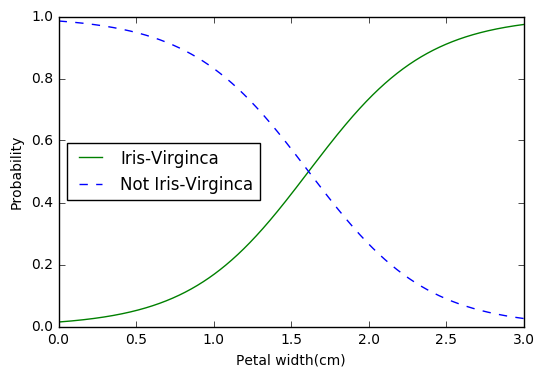

In [192]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris-Virginca")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris-Virginca")
plt.xlabel("Petal width(cm)")
plt.ylabel("Probability")
plt.legend(loc="best")

Now, we can get the decision boundry:

In [195]:
decision_boundry = X_new[y_proba[:,1]>=0.5][0]
decision_boundry

array([1.61561562])

There is a *decision boundary* at around 1.6cm where both probabilities are equal to 50%: if the petal width is higher than 1.6cm, the classifier will predict that the flower is an Iris-Virginca, or else it will predict that it is not (even if it is not very confident):

In [197]:
log_reg.predict([[1.7],[1.5]])

array([1, 0])

If we use petal length and width to train the Logistic Regression model, we can complete the training procedure as below:

In [198]:
X = iris["data"][:, (2, 3)]  # petal length and width
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris-Virginca, else 0

log_reg = LogisticRegression(solver="liblinear", C=10**10, random_state=42)
log_reg.fit(X,y)

LogisticRegression(C=10000000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Just like the other linear models, Losgistic Regression models can be regualrized using *l1* or *l2* penalties. Scikit-Learn actually adds an *l2* penalty by default.

The hyperparameter controlling the regularization strength of a Scikit-Learn *LogisticRegression* model is not *alpha* (as in other linear models), but its inverse: *C*. The higher the value of *C*, the *less* the model is regularized.

## Softmax Regression

The Logistic Regression model can be generalized to support multiple classes directly, without having to train and combine multiple binary classifiers. This is called *Softmax Regression*, or *Multinomial Logistic Regression*.

The ides is quite simple: when given an instance x, the Softmax Regression model first computes a score s[*k*]\(x) for each class by applying the *softmax function* (also called the *nomalized exponentional*) to the scores.

Once you have computed the score of every class for the instance x, you can estimate the probability *p(k)* that the instance belongs to class *k* by running the scores through the softmax function: it computes the exponential of every score, then normalizes them (dividing by the sum of all the exponentials).

Just like the Logistic Regression classifier, the Softmax Regression classifier predicts the class with the highest estimated probability (which is simply the class with the highest score).

The above cell shows how the model estimates probabilities and makes predictions, then we will show the training procedure.

The objective is to have a model that estimates a high probability for the target class and a low probability for the other classes. Minimizing the cost function which is called *cross entropy*, should lead to the objective because it penalizes the model when it estimates a low probability for a target class. Cross entropy is frequently used to measure how well a set of estimated class probalities match the target classes.

*Cross entropy cost function* is shown as *Equation 4-22*. Notice that when there are just two classes (K=2), this cost function is equivalent to the Logistic Regression's cost function (log loss).

Cross entropy measures the average number of bits you actually send per option. If your assumption about weather is perfect, cross entropy will just be equal to the entropy of the weather itself (i.e., its intrinsic unpredictability). But if your assumptions are wrong (e.g., if it rains often), cross entropy will be greater by an amount called the *Kullback-Leibler divergence*.

The cross entropy between two probability distributions *p* and *q* is defined as H(*p*,*q*) = -Σ(x)*p*(x)log*q*(x)(at least when the distributions are discrete).

+ Scikit-Learn's *LogisticRegression* uses one-versus-all by default when you train it on more than two classes, but you can set the *multi_class* hyperparameter to "*multinomial*" to switch it to Softmax Regression instead.
- You must specify a solver that supports Softmax Regression, such as "*lbfgs*" solver.
+ It also implies *l2* regularization by default, which you can control using the hyperparameter *C*.

In [200]:
X = iris["data"][:, (2, 3)]  # petal length and width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X,y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [202]:
softmax_reg.predict([[5, 2]])  # flower with 5cm long and 2cm wide petals

array([2])

In [203]:
softmax_reg.predict_proba([[5, 2]])

array([[6.33134077e-07, 5.75276067e-02, 9.42471760e-01]])